In [1]:
# Imports
import pandas as pd
import seaborn as sns
import xlrd


In [2]:
# Read data
crimes = pd.read_excel(
    "https://www1.nyc.gov/assets/nypd/downloads/excel/crime_statistics/cs-en-us-city.xlsx", skiprows=12)
crimes.head(2)

,Unnamed: 0,Unnamed: 1,2020,2019,% Chg,2020.1,2019.1,% Chg.1,2020.2,2019.2,% Chg.2,% Chg.3,% Chg.4,% Chg.5
0,Murder,NaN,3.0,6.0,-50.000000,18.0,16.0,12.500000,432.0,311.0,38.9068,52.6502,-16.2791,-76.3805
1,Rape,NaN,24.0,23.0,4.347826,103.0,113.0,-8.849558,1368.0,1711.0,-20.0468,-20.5113,3.32326,-55.9704


In [3]:
# Drop NaN columns
crimes = crimes[["Unnamed: 0", 2020, 2019, "% Chg"]]
crimes = crimes.dropna()

In [4]:
# Rename columns
crimes = crimes.rename(columns={"Unnamed: 0": "Crime"})

In [5]:
# Set index
crimes = crimes.set_index(crimes["Crime"])
crimes = crimes.drop("Crime", axis=1)

In [6]:
# Drop total
crimes = crimes.drop("TOTAL")

In [7]:
crimes.head(2)

,2020,2019,% Chg
Crime,,,
Murder,3.0,6.0,-50.000000
Rape,24.0,23.0,4.347826


## Bar Plot

In [8]:
import plotly.graph_objects as go

In [9]:
crimes_plot = crimes.reset_index()
graph = crimes_plot.drop(['% Chg'], axis=1)

In [10]:
fig = go.Figure([
    go.Bar(name='2019', x=graph['Crime'], y=crimes[2019]),
    go.Bar(name='2020', x=graph['Crime'], y=crimes[2020])
])

fig.update_layout(title='Crime in NYC (2019 vs 2020)',
                  xaxis=dict({'categoryorder': 'total ascending'},
                             title='Crime Committed'),
                  yaxis=dict(title='Number of Crimes'))

fig.show()

## Histogram

In [11]:
%matplotlib inline
import geopandas as gp
import numpy as np
from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 8, 6

In [12]:
file = "../Data/geo_export_12ba89da-ef97-439e-b420-f1f076a1c0a4.shp"
nyc = gp.read_file(file)
nyc.head(2)

,geometry
0,POINT (-73.93272 40.62889)
1,POINT (-73.94567 40.78196)


In [13]:
def heatmap(d, bins=(500,500), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

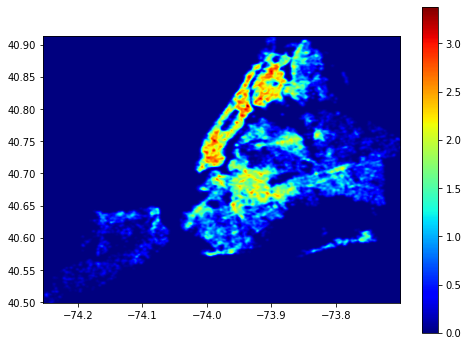

In [14]:
heatmap(nyc,
        bins=400)


# Machine Learning

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [16]:
crimes.reset_index(inplace=True)

In [17]:
dums = pd.get_dummies(crimes["Crime"])
crimes = crimes.join(dums)

new_crimes = crimes.drop(columns="Crime")

In [18]:
new_crimes.columns

Index([              2020,               2019,            '% Chg',
               'Burglary',     'Fel. Assault',           'G.L.A.',
            'Gr. Larceny',      'Hate Crimes',          'Housing',
          'Misd. Assault',           'Murder', 'Other Sex Crimes',
          'Petit Larceny',             'Rape',          'Robbery',
          'Shooting Inc.',    'Shooting Vic.',          'Transit',
              'UCR Rape*'],
      dtype='object')

In [19]:
X = new_crimes[[2020, 2019]]
y = new_crimes["Murder"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)

In [21]:
rfc = RandomForestClassifier()

params = {
    "n_estimators": [100, 1000, 1500],
    "criterion": ['gini', 'entropy'],
    "max_depth": [1, 5, 10],
    "max_features": ['auto', 'sqrt', 'log2'],
    "n_jobs": [-1],
    "random_state": [1]
}

In [22]:

grid = GridSearchCV(rfc, params).fit(X_train, y_train)
grid_df = pd.DataFrame(grid.cv_results_)

In [23]:
best_model = grid_df.loc[:"mean_test_score"].max()
best_model

mean_fit_time           1.60699
std_fit_time            1.38857
mean_score_time        0.484289
std_score_time        0.0836868
param_criterion            gini
param_max_depth              10
param_max_features         sqrt
param_n_estimators         1500
param_n_jobs                 -1
param_random_state            1
split0_test_score      0.666667
split1_test_score             1
split2_test_score             1
split3_test_score             1
split4_test_score             1
mean_test_score        0.933333
std_test_score         0.133333
rank_test_score               1
dtype: object

In [24]:
best_rfc = RandomForestClassifier(
    n_estimators = best_model.param_n_estimators,
    criterion = best_model.param_criterion,
    max_depth = best_model.param_max_depth,
    max_features = best_model.param_max_features,
    n_jobs = best_model.param_n_jobs,
    random_state = best_model.param_random_state,
).fit(X_train, y_train)


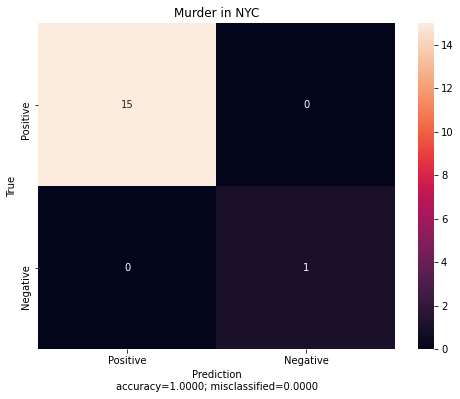

In [31]:
cm = confusion_matrix(y, best_rfc.predict(X))
accuracy = np.trace(cm) / np.sum(cm).astype("float")
misclass = 1 - accuracy

ax = plt.subplot()
sns.heatmap(cm, annot =True, fmt = 'd')
plt.title(label="Murder in NYC")
plt.xlabel(
    "Prediction\naccuracy={:0.4f}; misclassified={:0.4f}".format(accuracy, misclass)
)
plt.ylabel("True")
ax.xaxis.set_ticklabels(["Positive", "Negative"])
ax.yaxis.set_ticklabels(["Positive", "Negative"])

plt.show()


In [26]:
print(classification_report(y, best_rfc.predict(X)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00         1

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



In [36]:
def nyc_crimes(target, train_size):
    """
    Inputs:
        target : str : crime to classify
            available targets: Burglary, Fel. Assault, G.L.A., Gr. Larceny,            Hate Crimes, Housing, Misd. Assault, Murder, Other Sex Crimes,             Petit Larceny, Rape, Robbery, Shooting Inc., Shooting Vic.,                Transit, UCR Rape*
        train_size : float : size of training set < 1
    Output:
        cm : plot : confusion matrix of classification
    """
    # load data
    crimes = pd.read_excel(
    "https://www1.nyc.gov/assets/nypd/downloads/excel/crime_statistics/cs-en-us-city.xlsx", skiprows=12)

    # Drop NaN columns
    crimes = crimes[["Unnamed: 0", 2020, 2019, "% Chg"]]
    crimes = crimes.dropna()

    # Rename columns
    crimes = crimes.rename(columns={"Unnamed: 0": "Crime"}) 
    
    # get dummies
    dums = pd.get_dummies(crimes["Crime"])
    crimes = crimes.join(dums)

    # drop crimes column from before join
    new_crimes = crimes.drop(columns="Crime")

    # split data
    X = new_crimes[[2020, 2019]]
    y = new_crimes[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # build RandomForestClassifier
    rfc = RandomForestClassifier()
    params = {
        "n_estimators": [100, 1000, 1500],
        "criterion": ['gini', 'entropy'],
        "max_depth": [1, 5, 10],
        "max_features": ['auto', 'sqrt', 'log2'],
        "n_jobs": [-1],
        "random_state": [1]
    }

    # build GridSearchCV
    grid = GridSearchCV(rfc, params).fit(X_train, y_train)
    grid_df = pd.DataFrame(grid.cv_results_)

    # get best fitting model
    best_model = grid_df.loc[:"mean_test_score"].max()

    best_rfc = RandomForestClassifier(
        n_estimators = best_model.param_n_estimators,
        criterion = best_model.param_criterion,
        max_depth = best_model.param_max_depth,
        max_features = best_model.param_max_features,
        n_jobs = best_model.param_n_jobs,
        random_state = best_model.param_random_state,
    ).fit(X_train, y_train)

    y_pred = best_rfc.predict(X)

    # get results
    con_mat = confusion_matrix(y, y_pred)
    accuracy = np.trace(con_mat) / np.sum(con_mat).astype("float")
    misclassified = 1 - accuracy

    # plot results - confusion matrix
    ax = plt.subplot()
    sns.heatmap(con_mat, annot=True, fmt="d", cmap="YlGnBu")
    plt.title(label=target + " Confusion Matrix")
    plt.xlabel(
        "Predicted\naccuracy={:0.4f}; misclassified={:0.4f}".format(
            accuracy, misclassified
        )
    )
    plt.ylabel("True")
    ax.xaxis.set_ticklabels(["Positive", "Negative"])
    ax.yaxis.set_ticklabels(["Positive", "Negative"])
        
    return plt.show()

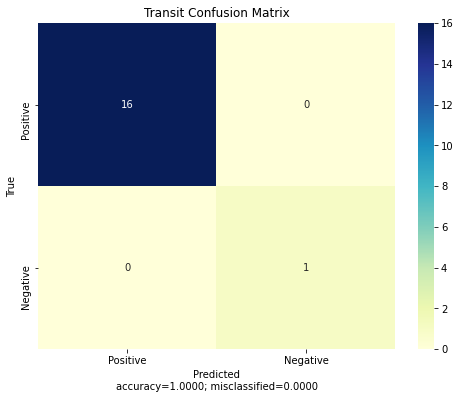

In [37]:
nyc_crimes("Transit", .7)

In [38]:
nyc_crimes("Hate Crimes", .7)

ValueError: n_splits=5 cannot be greater than the number of members in each class.